# Лабораторная работа №1
## Пункт 1: градиентный спуск и его исследование при разных значениях константного шага

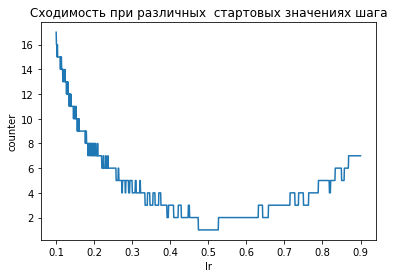

In [12]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

# helpers
f_calls_counter = 0
grad_calls_counter = 0
cur_lr = 0

# multidimension function in point [x_0, ..., x_n]
def f(x):
    a = x[0]
    return a**2 + 5*a + 10

# precalced grad of f
def grad_f(x):
    a = x[0]
    return np.asarray([2 * a + 5])


# compute gradinent of function f in point x
def grad(x, f) :
    global grad_calls_counter
    grad_calls_counter += 1
    h = 1e-5
    derivative = np.arange(np.size(x))
    for i in range(np.size(x)):
        x[i] += h
        f1 = f(x)
        x[i] -= 2 * h
        f2 = f(x)
        x[i] += h
        derivative[i] = (f1 - f2) / (2 * h)
    return derivative


# compute argument for step in gradient descent
# lr(cur_lr, epoch) - lamba, computing current learning rate
def next_x(x, lr, f, epoch = 0) : 
    global cur_lr 
    cur_lr = lr(cur_lr, epoch)
    return x - cur_lr * grad(x, f)

# find arg of multidim function f with min value by eps, lr() - lambda, x - starting point
# "gradient descent with additional information"
def get_min_by_f(f, eps, lr, x, start_lr = 0.1) :
    global cur_lr
    cur_lr = start_lr
    points = np.asarray([])
    counter = 0
    next = next_x(x, lr, f, counter)
    while LA.norm(next - x) > eps:
        counter += 1
        points = np.append(points, x)
        x = next
        next = next_x(x, lr, f, counter)
    return [x, counter, points]

# version with given hand-written gradient & no counter
# Args: grad(x) - gradient of function in point x
#       eps 
#       alpha(lr, epoch) - compute current_epoch_lr via old_lr old_epoch
#       x
#       start_lr
def get_min_by_grad(grad, eps, alpha, x, start_lr = 0.0002) :
    global grad_calls_counter
    points = np.asarray([])
    counter = 0
    lr = start_lr
    next = x - lr * grad(x)
    grad_calls_counter += 1
    while (LA.norm(next - x) > eps) :
        counter += 1
        points = np.append(points, x)
        x = next
        lr = alpha(lr, counter)
        next = x - lr * grad(x)
        grad_calls_counter += 1
    return [x, counter, points]

# Prepare the data
x = np.linspace(0.1, 0.9, 1000)
y = np.arange(np.size(x))
for i in range(np.size(x)):
    y[i] = get_min_by_f(f, 1e-6, (lambda lr, epoch: x[i]), np.asarray([7.]), x[i])[1]

# Plot the data
plt.plot(x, y, label='counter')

# Add a legend
plt.xlabel("lr")
plt.ylabel("counter")
plt.title("Сходимость при различных  стартовых значениях шага")

# Show the plot
plt.show()

## Пункт 2: градиентный спуск и его исследование при разных функциях изменения шага

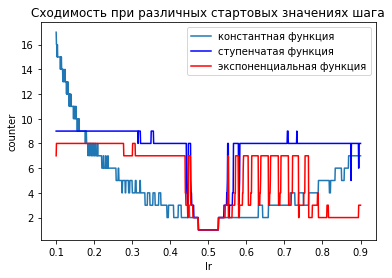

In [13]:
def step_decay(lr, epoch, epochs_drop = 2, drop = 0.5):
   return lr * pow(drop, floor((1+epoch)/epochs_drop))

def exp_decay(lr, epoch, k = 0.5):
   return lr * exp(-k*epoch) 


# Prepare the data
x = np.linspace(0.1, 0.9, 1000)
y1 = np.arange(np.size(x))
y2 = np.arange(np.size(x))
y3 = np.arange(np.size(x))

for i in range(np.size(x)):
   y1[i] = get_min_by_f(f, 1e-6, (lambda lr, epoch: x[i]), np.asarray([7.]), x[i])[1]
   y2[i] = get_min_by_f(f, 1e-6, (lambda lr, epoch: step_decay(lr, epoch)), np.asarray([7.]), x[i])[1]
   y3[i] = get_min_by_f(f, 1e-6, (lambda lr, epoch: exp_decay(lr, epoch)), np.asarray([7.]), x[i])[1]

# Plot the data
plt.plot(x, y1, label='константная функция')
plt.plot(x, y2, label='ступенчатая функция', color='blue')
plt.plot(x, y3, label='экспоненциальная функция', color='red')


# Add a legend
plt.xlabel("lr")
plt.ylabel("counter")
plt.title("Сходимость при различных стартовых значениях шага")
plt.legend()

# Show the plot
plt.show()


## Пункт 3: Градиентный спуск на основе дихотомии. Сравнение с константным шагом

In [14]:
# 3d Rosenbrock function in point [x, y]
def function_rosenbrok(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

def point_function_rosenbrok(p):
    x = p[0]
    y = p[1]
    return function_rosenbrok(x, y)

# precalced grad of rosenbrok
def grad_rosenbrok(p):
    x = p[0]
    y = p[1]
    return np.asarray([2 * (-1 + x + 200*x**3 - 200*x*y), -200*(x**2 - y)])

In [15]:
# version with given hand-written gradient & no counter
# Args: grad(x) - gradient of function in point x
#       eps 
#       alpha(x) - compute current_epoch_lr via dichotomy call/constant step
#       x
def dichotomy_get_min(grad, eps, alpha, x):
    global grad_calls_counter
    points = np.asarray([])
    counter = 0
    next = x - alpha(x) * grad(x)
    grad_calls_counter += 1
    while LA.norm(next - x) > eps:
        counter += 1
        points = np.append(points, x)
        x = next
        next = x - alpha(x) * grad(x)
        grad_calls_counter += 1
    return [x, counter, points]

# Find best lr value for function f to make next step from point x
# Args: f(lr) = f_optimizing(x - lr * grad(f, x)) - convex function
#       x - point for lr computing
#       left, right - searching inteval points
#       eps - computed interval size upper bound
# Returns: lr - mid point in computed interval
def dichotomy_invoker(f, grad, x, left, right, eps):
    global f_calls_counter
    original_left = left
    original_right = right
    delta = eps / 4

    while right - left >= eps:
        mid = (left + right) / 2
        while mid + delta > original_right or mid - delta < original_left:
            delta /= 2

        lr1 = mid - delta
        lr2 = mid + delta
        f_lr1 = f(x - lr1 * grad(x))
        f_calls_counter += 1
        f_lr2 = f(x - lr2 * grad(x))
        f_calls_counter += 1
        
        if f_lr1 < f_lr2:
            right = lr2
        elif f_lr1 > f_lr2:
            left = lr1
        else:
            left = lr1
            right = lr2
            delta /= 2
    return (left + right) / 2


# Determine interval for lr searching
def dichotomy_interval_determinator(f, grad, x):
    global f_calls_counter
    step = 0.01
    left = 0.1
    right = left
    
    previous_value = f(x - left * grad(x))
    f_calls_counter += 1
    while right < 1:
        right += step
        stepped_value = f(x - right * grad(x))
        f_calls_counter += 1
        if stepped_value > previous_value:
            break
        previous_value = stepped_value
    return [left, right]

# Compute best learning rate
def dichotomy(f, grad, x):
    interval = dichotomy_interval_determinator(f, grad, x)
    return dichotomy_invoker(f, grad, x, interval[0], interval[1], 1e-6)

# Calls & graphics
def compare_dichotomy_to_constant(f, grad, starting_x):
    global f_calls_counter
    global grad_calls_counter

    # dichotomy
    f_calls_counter = 0
    grad_calls_counter = 0
    dichotomy_ds_result = dichotomy_get_min(grad, 1e-6, (lambda a: dichotomy(f, grad, np.asarray(a))), starting_x)
    print("Сходимость для шага, вычисленного дихотомией: " + str(dichotomy_ds_result[1]))
    print("Количество вызовов функции f: " + str(f_calls_counter))
    print("Количество вызовов функции grad: " + str(grad_calls_counter))

    # constant
    lr_step = np.linspace(0.1, 0.9, 1000)
    f_calls = np.arange(np.size(lr_step))
    grad_calls = np.arange(np.size(lr_step))
    steps = np.arange(np.size(lr_step))
    
    for i in range(np.size(lr_step)):
        f_calls_counter = 0
        grad_calls_counter = 0
        try:
            steps[i] = dichotomy_get_min(grad, 1e-6, (lambda a: lr_step[i]), starting_x)[1]
        except OverflowError:
            steps[i] = -1
            f_calls_counter = 0
            grad_calls_counter = 0

        f_calls[i] = f_calls_counter
        grad_calls[i] = grad_calls_counter

    # Counters graphics
    plt.plot(lr_step, f_calls, label='f_calls_counter', color='green')
    plt.plot(lr_step, grad_calls, label='grad_calls_counter', color='red')

    plt.xlabel("размер шага")
    plt.ylabel("колечество вызовов")
    plt.title("Количество вызовов f и grad при различных значениях шага")
    plt.legend()

    plt.show()

    # Epoch graphics
    plt.cla()
    plt.plot(lr_step, steps, label='steps')
    plt.xlabel("размер шага")
    plt.ylabel("колечество эпох")
    plt.title("Количество эпох при различных значениях шага")
    plt.show()


Сходимость для шага, вычисленного дихотомией: 1
Количество вызовов функции f: 157
Количество вызовов функции grad: 2


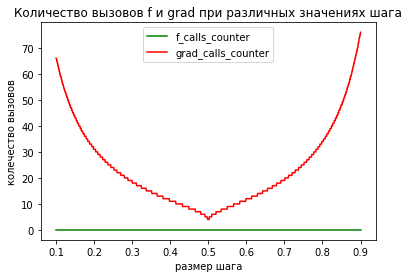

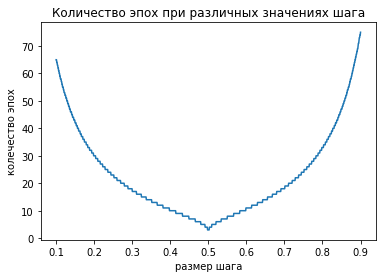

In [16]:
compare_dichotomy_to_constant(f, grad_f, np.asarray([7.]))

C:\Users\11\AppData\Local\Temp/ipykernel_23040/2012397338.py:3: RuntimeWarning: overflow encountered in double_scalars
  return (1 - x)**2 + 100 * (y - x**2)**2
C:\Users\11\AppData\Local\Temp/ipykernel_23040/2012397338.py:14: RuntimeWarning: overflow encountered in double_scalars
  return np.asarray([2 * (-1 + x + 200*x**3 - 200*x*y), -200*(x**2 - y)])
C:\Users\11\AppData\Local\Temp/ipykernel_23040/2012397338.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return np.asarray([2 * (-1 + x + 200*x**3 - 200*x*y), -200*(x**2 - y)])


Сходимость для шага, вычисленного дихотомией: 8
Количество вызовов функции f: 471
Количество вызовов функции grad: 9


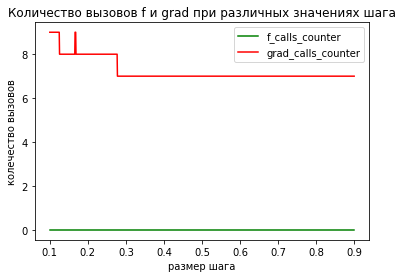

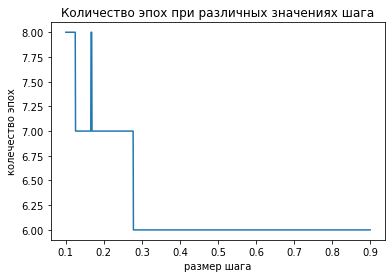

In [17]:
compare_dichotomy_to_constant(point_function_rosenbrok, grad_rosenbrok, np.asarray([0., 0.]))

## Пункт 5: анализ траектории градиентного спуска

In [18]:
def function_x2_y2(x,y):
    return  4 * x * x + 3 * y * y

def grad_x2_y2(p):
    x = p[0]
    y = p[1]
    return np.asarray([2 * x, 6 * y])

In [19]:
def line_of_levels(f, grad_f, lr, starting_x):
    fig, ax = plt.subplots()
    points=get_min_by_grad(grad_f, 1e-6, lr, starting_x)[2]

    points = np.asarray(points).reshape(-1, 2)
    # print(points)

    ax.plot(points[:, 0], points[:, 1], 'o-')
    ax.contour(xgrid, ygrid, f(xgrid, ygrid), levels=sorted([f(p[0], p[1]) for p in points]))
    plt.show()

In [20]:
def picture_function(f) :
    fig = plt.figure(figsize=(7,4))
    ax_3d = fig.add_subplot(projection='3d')

    x = np.arange(-2*np.pi, 2*np.pi, 0.2)
    y = np.arange(-2*np.pi, 2*np.pi, 0.2)

    global xgrid, ygrid
    xgrid, ygrid = np.meshgrid(x,y)

    ax_3d.plot_surface(xgrid,ygrid,f(xgrid, ygrid))
    
    plt.show()

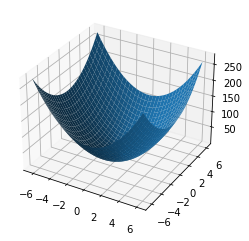

[[ 4.00000000e+00 -6.00000000e+00]
 [ 3.99840000e+00 -5.99280000e+00]
 [ 3.51859200e+00 -3.83539200e+00]
 [ 3.09636096e+00 -2.45465088e+00]
 [ 2.72479764e+00 -1.57097656e+00]
 [ 2.39782193e+00 -1.00542500e+00]
 [ 2.11008330e+00 -6.43472000e-01]
 [ 1.85687330e+00 -4.11822080e-01]
 [ 1.63404850e+00 -2.63566131e-01]
 [ 1.43796268e+00 -1.68682324e-01]
 [ 1.26540716e+00 -1.07956687e-01]
 [ 1.11355830e+00 -6.90922799e-02]
 [ 9.79931306e-01 -4.42190592e-02]
 [ 8.62339549e-01 -2.83001979e-02]
 [ 7.58858804e-01 -1.81121266e-02]
 [ 6.67795747e-01 -1.15917610e-02]
 [ 5.87660257e-01 -7.41872707e-03]
 [ 5.17141027e-01 -4.74798532e-03]
 [ 4.55084103e-01 -3.03871061e-03]
 [ 4.00474011e-01 -1.94477479e-03]
 [ 3.52417130e-01 -1.24465586e-03]
 [ 3.10127074e-01 -7.96579753e-04]
 [ 2.72911825e-01 -5.09811042e-04]
 [ 2.40162406e-01 -3.26279067e-04]
 [ 2.11342917e-01 -2.08818603e-04]
 [ 1.85981767e-01 -1.33643906e-04]
 [ 1.63663955e-01 -8.55320997e-05]
 [ 1.44024281e-01 -5.47405438e-05]
 [ 1.26741367e-01 -3

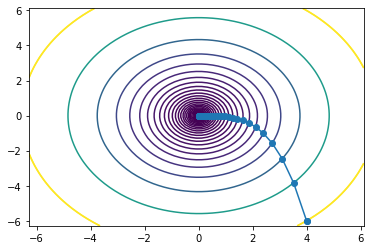

In [21]:
picture_function(function_x2_y2)
line_of_levels(function_x2_y2, grad_x2_y2, (lambda lr, epoch: 0.06), np.asarray([4., -6.]))

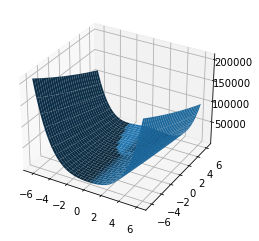

[[ 4.         -6.        ]
 [-3.0412     -5.12      ]
 [ 0.45631175 -4.5452441 ]
 ...
 [ 0.82076014  0.6728502 ]
 [ 0.82076256  0.67285418]
 [ 0.82076377  0.67285618]]


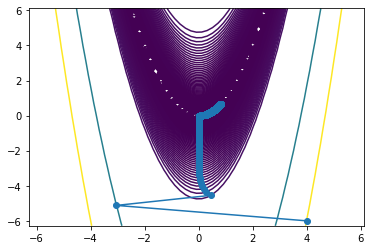

In [22]:
picture_function(function_rosenbrok)
line_of_levels(function_rosenbrok, grad_rosenbrok, (lambda lr, epoch: step_decay(lr, epoch, epochs_drop=10000)), np.asarray([4., -6.]))